## Toxic Comment Classification THE TRAINING

## PART II

In [2]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

In [3]:
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [6]:
train = pd.read_csv('../Toxic-Comment-Classification/input/train.csv', nrows = 200 )
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
temp = train[train['toxic'] == 1]
temp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [8]:
print(len(train['comment_text'][10]), 'Total Characters')
train['comment_text'][10]

2875 Total Characters


'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [9]:
labels = train.drop(['id', 'comment_text'], axis = 1)
unique_values = lambda x: train[x].unique()
[unique_values(col) for col in labels.columns.tolist()]

[array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64)]

In [10]:
test = pd.read_csv('../Toxic-Comment-Classification/input/train.csv', nrows = 10)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
test_labels = pd.read_csv('../Toxic-Comment-Classification/input/test_labels.csv', nrows = 10)
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
submission = pd.read_csv('../Toxic-Comment-Classification/input/sample_submission.csv', nrows = 10)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [11]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [12]:
df_train = train.drop(['id', 'comment_text'], axis = 1)
label_counts = df_train.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 

,counts
toxic,20
insult,12
obscene,11
severe_toxic,3
identity_hate,3
threat,2


In [16]:
train.shape, test.shape

((200, 8), (100, 2))

In [17]:
def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    #pattern = [zero or more character]

    text = re.sub('https?://\S+|www\.\S+', '', text)
    #pattern = removes (http),://, 'and' www.
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #pattern = any punctionation

    text = re.sub('\n', '', text)
    #pattern = any new line

    text = re.sub('\w*\d\w*', '', text)
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]

    return text

In [18]:
%%time
train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

CPU times: user 18.8 ms, sys: 1.76 ms, total: 20.5 ms
Wall time: 22.1 ms


In [19]:
kfold = 5
train['kfold'] = train.index % kfold
train.index % kfold

Int64Index([0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
            ...
            0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
           dtype='int64', length=200)

In [20]:
p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

In [21]:
p_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,kfold
0,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,1
1,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,2
2,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,MoreI cant make any real suggestions on improv...,3
3,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,4
4,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1


In [14]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [23]:
%%time
senten_len = []
#tqdm is progress bar
for sentence in tqdm(p_train['clean_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

100%|██████████| 160/160 [00:00<00:00, 549.28it/s]

CPU times: user 278 ms, sys: 0 ns, total: 278 ms
Wall time: 298 ms


In [25]:
max_len = 256

We define a class BertDataSet with Dataset as super class and overwirte the __init__, __len__ and __getitem__ function in it. It will get the comment list and relevant toxic labels (6 labels in this case) and creates token ids and attention mask to distinguish the comments from the zero padding.


torch.tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but (and more importantly) the computational graph leading to these values. This computational graph is then used (using the chain rule of derivatives) to compute the derivative of the loss function w.r.t each of the independent variables used to compute the loss.

In [26]:
class BertDataSet(Dataset):
#Bidirectional Encoder Representations from Transformers
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [27]:
train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

In [ ]:
# for a in train_dataset:
#     print(a)
#     break

In [28]:
train_batch = 32
valid_batch = 32

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
%%time
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)
model.train()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

CPU times: user 10.9 s, sys: 2.73 s, total: 13.6 s
Wall time: 31 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
%%time
for a in train_dataloader:
    ids = a['ids'].to(device)
    mask = a['mask'].to(device)
    output = model(ids, mask)
    break

CPU times: user 255 ms, sys: 330 ms, total: 585 ms
Wall time: 1.48 s


In [33]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.6017,  0.2479,  0.2723, -0.3441, -1.3885,  0.4064],
        [ 0.4567, -0.0078, -0.0191, -0.3889, -0.7906,  0.5614],
        [ 0.7998,  0.3766,  0.3531, -0.5736, -0.7189,  0.4381],
        [ 0.3035,  0.5193, -0.0605, -0.2462, -0.5226,  0.0330],
        [ 0.8461,  0.2627,  0.1485, -0.7878, -0.7976,  0.3545],
        [ 0.4831,  0.5087,  0.0793, -0.6815, -0.6536,  0.3773],
        [ 0.8168,  0.0911,  0.1609, -0.6440, -1.0457,  0.3564],
        [ 0.3088,  0.5284,  0.2240, -0.7453, -0.5855,  0.5366],
        [ 0.5404,  0.3837,  0.2853, -0.3923, -0.7455,  0.2067],
        [ 0.5403,  0.3118, -0.2642, -0.4825, -0.5586,  0.1969],
        [ 0.5535, -0.1356,  0.0682, -0.2863, -0.7451,  0.3479],
        [ 0.4830,  0.2192,  0.3116, -0.3637, -0.7746,  0.1981],
        [ 0.8242,  0.1843,  0.1127, -0.5232, -0.8637,  0.5294],
        [ 0.4772,  0.4394, -0.2588, -0.4764, -0.7564,  0.3773],
        [ 0.2178,  0.3392,  0.0494, -0.3300, -0.5364,  0.5813

In [34]:
func.softmax(output['logits'], dim = 1)

tensor([[0.2653, 0.1863, 0.1909, 0.1030, 0.0363, 0.2182],
        [0.2453, 0.1541, 0.1524, 0.1053, 0.0705, 0.2724],
        [0.2887, 0.1891, 0.1847, 0.0731, 0.0632, 0.2011],
        [0.2122, 0.2633, 0.1474, 0.1224, 0.0929, 0.1619],
        [0.3272, 0.1826, 0.1629, 0.0639, 0.0632, 0.2002],
        [0.2366, 0.2428, 0.1580, 0.0738, 0.0759, 0.2129],
        [0.3310, 0.1602, 0.1718, 0.0768, 0.0514, 0.2089],
        [0.1931, 0.2406, 0.1774, 0.0673, 0.0790, 0.2426],
        [0.2490, 0.2129, 0.1929, 0.0980, 0.0688, 0.1784],
        [0.2743, 0.2183, 0.1227, 0.0986, 0.0914, 0.1946],
        [0.2750, 0.1381, 0.1693, 0.1187, 0.0751, 0.2239],
        [0.2453, 0.1885, 0.2067, 0.1052, 0.0698, 0.1845],
        [0.3117, 0.1644, 0.1530, 0.0810, 0.0576, 0.2322],
        [0.2485, 0.2393, 0.1191, 0.0958, 0.0724, 0.2249],
        [0.1831, 0.2067, 0.1547, 0.1059, 0.0861, 0.2634],
        [0.2278, 0.2297, 0.1526, 0.0952, 0.0616, 0.2331],
        [0.2637, 0.2299, 0.0966, 0.0731, 0.0664, 0.2704],
        [0.298

In [35]:
output_probs = func.softmax(output['logits'], dim = 1)

In [36]:
torch.max(output_probs, dim = 1)

torch.return_types.max(
values=tensor([0.2653, 0.2724, 0.2887, 0.2633, 0.3272, 0.2428, 0.3310, 0.2426, 0.2490,
        0.2743, 0.2750, 0.2453, 0.3117, 0.2485, 0.2634, 0.2331, 0.2704, 0.2982,
        0.2640, 0.2344, 0.2756, 0.2162, 0.2456, 0.2311, 0.2248, 0.2159, 0.2432,
        0.2432, 0.2447, 0.2714, 0.2761, 0.2820], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([0, 5, 0, 1, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 0, 0, 1, 0,
        0, 0, 0, 5, 5, 0, 0, 0], device='cuda:0'))

In [37]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

In [38]:
train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)

BCEWithLogitsLoss()

In [41]:
scaler = torch.cuda.amp.GradScaler()

In [42]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

In [43]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

In [44]:
%%time

best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

train losses: 0.6814 train accuracy: 0.451
valid losses: 0.6521 valid accuracy: 0.475
Found a good model!


 20%|██        | 1/5 [00:07<00:28,  7.11s/it]

train losses: 0.6484 train accuracy: 0.525
valid losses: 0.6473 valid accuracy: 0.479
Found a good model!


 60%|██████    | 3/5 [00:25<00:16,  8.15s/it]

train losses: 0.6610 train accuracy: 0.522
valid losses: 0.6473 valid accuracy: 0.479


 80%|████████  | 4/5 [00:30<00:06,  6.59s/it]

train losses: 0.6561 train accuracy: 0.531
valid losses: 0.6473 valid accuracy: 0.479


100%|██████████| 5/5 [00:34<00:00,  6.84s/it]

train losses: 0.6675 train accuracy: 0.525
valid losses: 0.6473 valid accuracy: 0.479
CPU times: user 20.5 s, sys: 4.62 s, total: 25.1 s
Wall time: 34.2 s


Text(0.5, 0.98, 'Fold = 0')

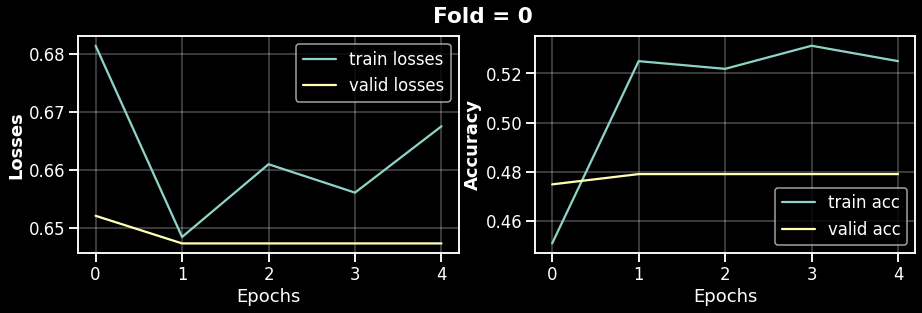

In [45]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 


In [46]:
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

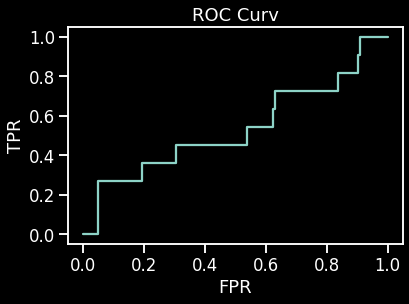

In [47]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [48]:
auc(fpr, tpr)

0.537911869789599